## MDAnalysis Script for Replica Exchange Trajectory Analysis in a Jupyter Notebook

This script provides functions to load, align, and analyze multi-frame PDB
files from a Replica Exchange Molecular Dynamics (REMD) simulation.

It calculates:
1. RMSD (Root Mean Square Deviation) against a reference.
2. RMSF (Root Mean Square Fluctuation) per residue.
3. Radius of Gyration (Rg).
4. Secondary Structure Content (Q3) - A useful metric for folding state.
5. Minimum Distances (e.g., between N-terminus and C-terminus) - To track folding/unfolding.

Assumptions:
- All PDB files contain the same protein structure/sequence.
- The reference PDB file (e.g., 'native_structure.pdb') represents the desired folded state.

In [13]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
from MDAnalysis.analysis import rms, density, distances
from MDAnalysis.analysis.dssp import DSSP

In [14]:
# --- CONFIGURATION ---
# Define the file paths for your analysis
no_structures = 12

REFERENCE_FILE = "PRO403-BB-AA.pdb" # The PDB of your target reference structure
REPLICAS = [f"replicas/replica_{i}_AA.pdb" for i in range(1, no_structures+1)]  # List of replica files (trajectories)
STATES = [f"states/state_{i}_AA.pdb" for i in range(1, no_structures+1)]    # List of state files (trajectories)
TRAJECTORY_FILES = REPLICAS + STATES # Combine all files to process them
# TRAJECTORY_FILES = STATES

# Selection string for alignment and analysis (e.g., 'protein' or 'protein and backbone')
# 'protein and name CA' is often a good choice for RMSD/RMSF in folding
# 'protein and backbone' is a standard choice for alignment
SELECTION = "protein and name CA"

In [15]:
# --- HELPER FUNCTIONS ---

def load_and_align_trajectory(trajectory_file, reference_file, selection):
    """Loads a trajectory and aligns all frames to the reference structure."""
    if not os.path.exists(trajectory_file):
        print(f"Warning: File not found: {trajectory_file}. Skipping.")
        return None

    # Load the reference and the trajectory
    ref = mda.Universe(reference_file)
    mobile = mda.Universe(trajectory_file)

    # Check for empty universe after loading (e.g., if PDB is malformed)
    if not mobile.select_atoms("all"):
        print(f"Error: Could not load atoms from {trajectory_file}. Skipping.")
        return None

    # Perform alignment on the selected atoms
    aligner = rms.RMSD(
        mobile,
        ref,
        select=selection,
        groupselections=[selection, selection] # Both groups should use the same selection
    )
    aligner.run()

    # The mobile Universe is now implicitly aligned via the results object
    return mobile, aligner.results.rmsd, ref, mobile

In [ ]:
def calculate_segment_rmsd_for_fel(trajectory_file, reference_file):
    """
    Calculates the RMSD for two overlapping segments (first 3/5ths and last 3/5ths)
    of a protein trajectory, after aligning the entire structure.

    Args:
        trajectory_file (str): Path to the trajectory file (e.g., .xtc, .dcd).
        reference_file (str): Path to the reference structure file (e.g., .pdb).

    Returns:
        np.ndarray or None: A N x 2 array where N is the number of frames.
                            Column 0 is RMSD(Segment A), Column 1 is RMSD(Segment B).
                            Returns None on error.
    """
    if not os.path.exists(trajectory_file):
        print(f"Warning: File not found: {trajectory_file}. Skipping.")
        return None

    # Load the reference and the trajectory
    ref = mda.Universe(reference_file)
    mobile = mda.Universe(trajectory_file)

    # 1. Check for atom count and calculate segment boundaries
    n_residues = len(ref.residues)
    if n_residues == 0:
        print(f"Error: No residues found in the reference structure.")
        return None

    # Calculate the split points
    # The selection is based on residue indices (resnum), which typically start at 1.
    split_point_A = int(np.ceil(0.6 * n_residues)) # 3/5ths point for Segment A end
    split_point_B = n_residues - int(np.floor(0.6 * n_residues)) + 1 # 3/5ths point for Segment B start

    # 2. Define the selection strings
    # Segment A: First 3/5ths (Residues 1 to split_point_A)
    # Segment B: Last 3/5ths (Residues split_point_B to n_residues)

    # Select backbone
    main_selection = "backbone" # Use the whole protein's backbone for global alignment
    selection_A = f"resid 1:{split_point_A} and {main_selection}"
    selection_B = f"resid {split_point_B}:{n_residues} and {main_selection}"

    print(f"Total residues: {n_residues}")
    print(f"Segment A selection: {selection_A} (Approx residues 1 to {split_point_A})")
    print(f"Segment B selection: {selection_B} (Approx residues {split_point_B} to {n_residues})")
    print(f"Alignment selection: {main_selection}")

    # 3. Perform GLOBAL alignment on the entire trajectory
    # Align the 'mobile' trajectory using the entire structure selection to the reference
    aligner = rms.RMSD(
        mobile,
        ref,
        select=main_selection,
        groupselections=[main_selection, main_selection]
    )
    aligner.run()

    # The trajectory (mobile) is now aligned implicitly by the alignment data stored in aligner.results.
    # The actual coordinates are NOT changed in the mobile Universe, 
    # but the MDAnalysis RMSD classes know how to apply the transforms.

    # 4. Calculate Segment RMSDs using the ALIGNED trajectory
    # The RMSD is calculated using the ALIGNED coordinates relative to the REFERENCE.
    rmsd_A = rms.RMSD(
        mobile,
        ref,
        select=selection_A,
        groupselections=[main_selection, selection_A] # Align to ALL, then calculate RMSD on A
    ).run().results.rmsd[:, 2] # Extract the RMSD column (index 2)

    rmsd_B = rms.RMSD(
        mobile,
        ref,
        select=selection_B,
        groupselections=[main_selection, selection_B] # Align to ALL, then calculate RMSD on B
    ).run().results.rmsd[:, 2] # Extract the RMSD column (index 2)

    # Combine the results into a single N x 2 array
    # N x 3 (Frame, Time, RMSD) -> N x 1 (RMSD)
    rmsd_data = np.column_stack((rmsd_A, rmsd_B))

    return rmsd_data

# Example of how you would call and use the function:
# trajectory_file = "simulation.xtc"
# reference_file = "minimized.pdb"
# rmsd_results = calculate_segment_rmsd_for_fel(trajectory_file, reference_file)

In [17]:
"""Main function to run the full analysis pipeline."""
# Ensure the reference file exists before proceeding
if not os.path.exists(REFERENCE_FILE):
    print(f"Error: Reference file not found: {REFERENCE_FILE}. Please create a placeholder or check the path.")

In [18]:
# List to hold all results
all_rmsd_results = {}

print(f"Starting analysis with Reference: {REFERENCE_FILE}...")

for file_path in TRAJECTORY_FILES:
    file_tag = os.path.basename(file_path).replace(".pdb", "")
    print(f"\n--- Analyzing: {file_tag} ---")

    # Step 1: Load and Align
    rmsd_data = calculate_segment_rmsd_for_fel(file_path, REFERENCE_FILE)
    all_rmsd_results[file_tag] = rmsd_data


print("\n--- Analysis Complete ---")

Starting analysis with Reference: PRO403-BB-AA.pdb...

--- Analyzing: replica_1_AA ---
Total residues: 392
Segment A selection: resid 1:236 and backbone (Approx residues 1 to 236)
Segment B selection: resid 158:392 and backbone (Approx residues 158 to 392)
Alignment selection: backbone


/Users/clairenoble/mambaforge/envs/jupyter/lib/python3.12/site-packages/MDAnalysis/analysis/base.py:562: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time
/Users/clairenoble/mambaforge/envs/jupyter/lib/python3.12/site-packages/MDAnalysis/coordinates/base.py:759: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.time



--- Analyzing: replica_2_AA ---
Total residues: 392
Segment A selection: resid 1:236 and backbone (Approx residues 1 to 236)
Segment B selection: resid 158:392 and backbone (Approx residues 158 to 392)
Alignment selection: backbone

--- Analyzing: replica_3_AA ---
Total residues: 392
Segment A selection: resid 1:236 and backbone (Approx residues 1 to 236)
Segment B selection: resid 158:392 and backbone (Approx residues 158 to 392)
Alignment selection: backbone

--- Analyzing: replica_4_AA ---
Total residues: 392
Segment A selection: resid 1:236 and backbone (Approx residues 1 to 236)
Segment B selection: resid 158:392 and backbone (Approx residues 158 to 392)
Alignment selection: backbone

--- Analyzing: replica_5_AA ---
Total residues: 392
Segment A selection: resid 1:236 and backbone (Approx residues 1 to 236)
Segment B selection: resid 158:392 and backbone (Approx residues 158 to 392)
Alignment selection: backbone

--- Analyzing: replica_6_AA ---
Total residues: 392
Segment A selec

In [19]:
def plot_free_energy_landscape(rmsd_data, T, filename="fel_plot.png"):
    """
    Calculates the Free Energy Landscape (FEL) from 2D RMSD data 
    and generates a contour plot.
    
    Args:
        rmsd_data (np.ndarray): N x 2 array of RMSD values.
        T (float): Simulation temperature in Kelvin.
        filename (str): Output filename for the plot.
    """
    R = 8.31446 / 1000.0  # Gas constant in kJ/(mol*K)
    kT = R * T            # kT in kJ/mol

    # 1. Create 2D Histogram (Binning)
    # Automatically determine bin range and use 50x50 bins
    max_A = np.ceil(rmsd_data[:, 0].max() * 10) / 10.0 + 0.1
    max_B = np.ceil(rmsd_data[:, 1].max() * 10) / 10.0 + 0.1
    bins = 50
    
    counts, x_edges, y_edges = np.histogram2d(
        rmsd_data[:, 0],       # RMSD Segment A (X-axis)
        rmsd_data[:, 1],       # RMSD Segment B (Y-axis)
        bins=bins,
        range=[[0, max_A], [0, max_B]]
    )

    # 2. Convert Counts to Probability (P)
    # Transpose P for correct plotting orientation (x vs y)
    P = counts.T / np.sum(counts) 
    
    # 3. Calculate Free Energy (Delta G)
    # G = -kT * ln(P/P_max)
    P_max = P.max()
    
    # Set a small minimum probability to avoid log(0)
    min_P = 1e-10
    P[P < min_P] = min_P 
    
    G = -kT * np.log(P / P_max)

    # 4. Prepare coordinates for plotting (centers of the bins)
    X_centers = (x_edges[:-1] + x_edges[1:]) / 2.0
    Y_centers = (y_edges[:-1] + y_edges[1:]) / 2.0
    
    # 5. Plotting
    plt.figure(figsize=(10, 8))

    # Define contour levels (e.g., in steps of 5 kJ/mol)
    G_max_plot = np.ceil(G.max()/5) * 5
    levels = np.arange(0, G_max_plot, 5)

    # Plot filled contours (FEL surface)
    CF = plt.contourf(X_centers, Y_centers, G, levels=levels, cmap='viridis_r', extend='max')

    # Add black contour lines for clarity
    CS = plt.contour(X_centers, Y_centers, G, levels=levels, colors='k', linewidths=0.5)
    
    # Label the contour lines
    plt.clabel(CS, inline=1, fontsize=10, fmt='%.1f')

    # Add a color bar
    cbar = plt.colorbar(CF, ticks=levels)
    cbar.set_label(r'$\Delta G$ $(\mathrm{kJ/mol})$', fontsize=14)

    # Set axis labels with LaTeX formatting
    plt.xlabel(r'$\mathrm{RMSD_{Segment\ A}}$ ($\mathrm{\AA}$)', fontsize=14)
    plt.ylabel(r'$\mathrm{RMSD_{Segment\ B}}$ ($\mathrm{\AA}$)', fontsize=14)
    
    # Set title
    plt.title(r'Free Energy Landscape at $T = ' + f'{T}' + r'\ \mathrm{K}$', fontsize=16)
    
    plt.xlim(X_centers.min(), X_centers.max())
    plt.ylim(Y_centers.min(), Y_centers.max())

    plt.tight_layout()
    plt.savefig(filename)



/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_54393/1771877872.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


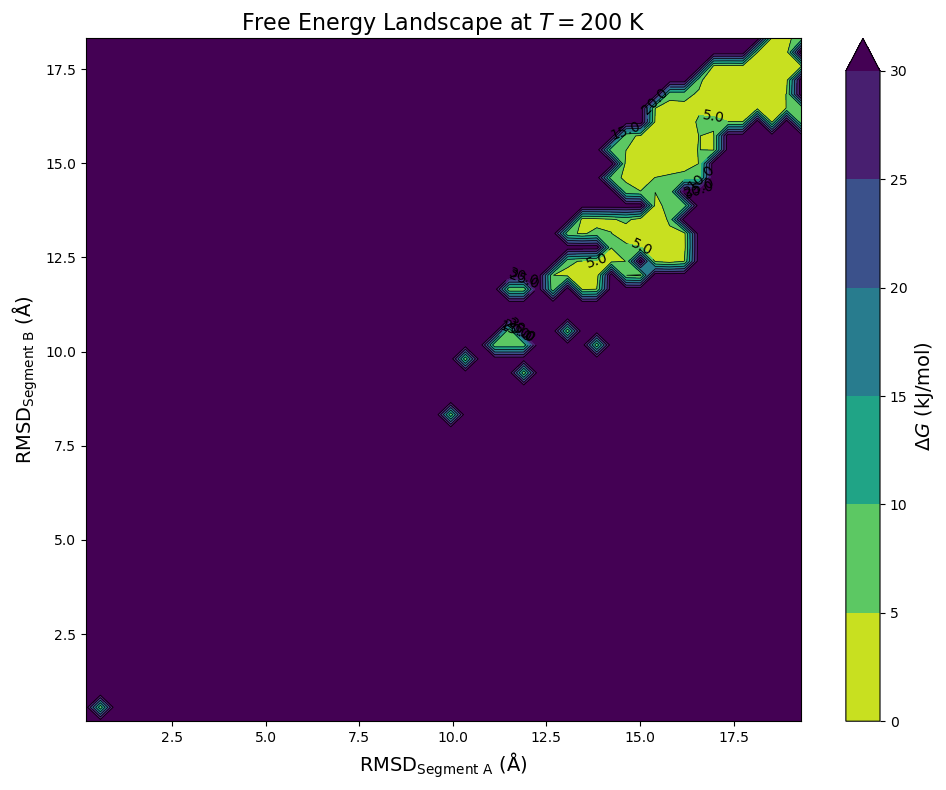

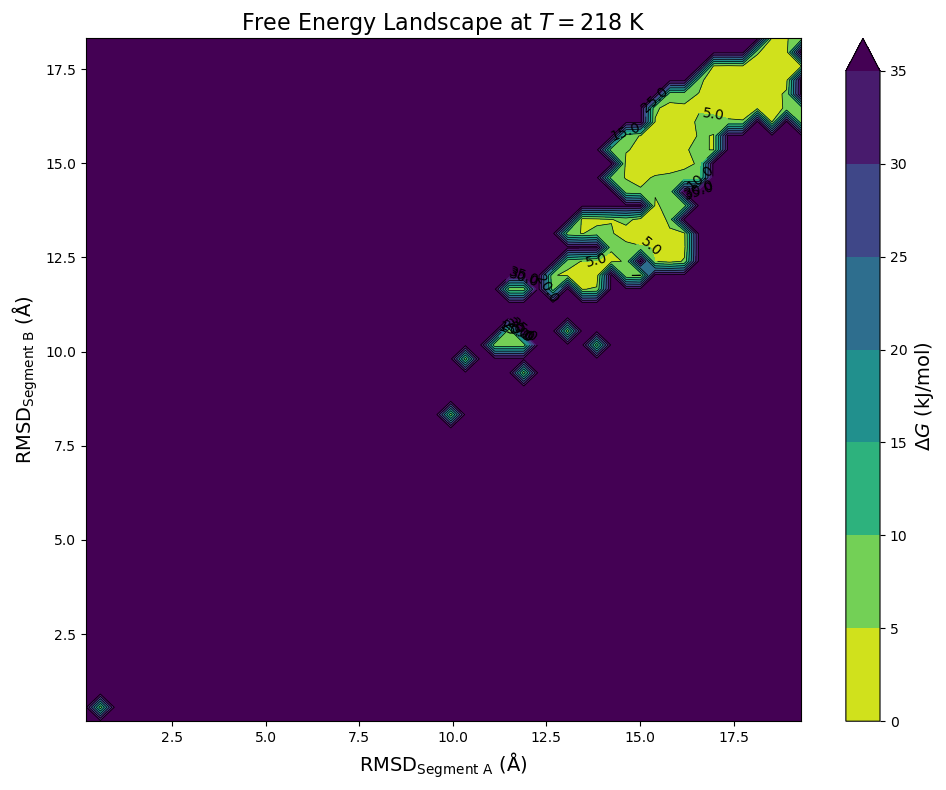

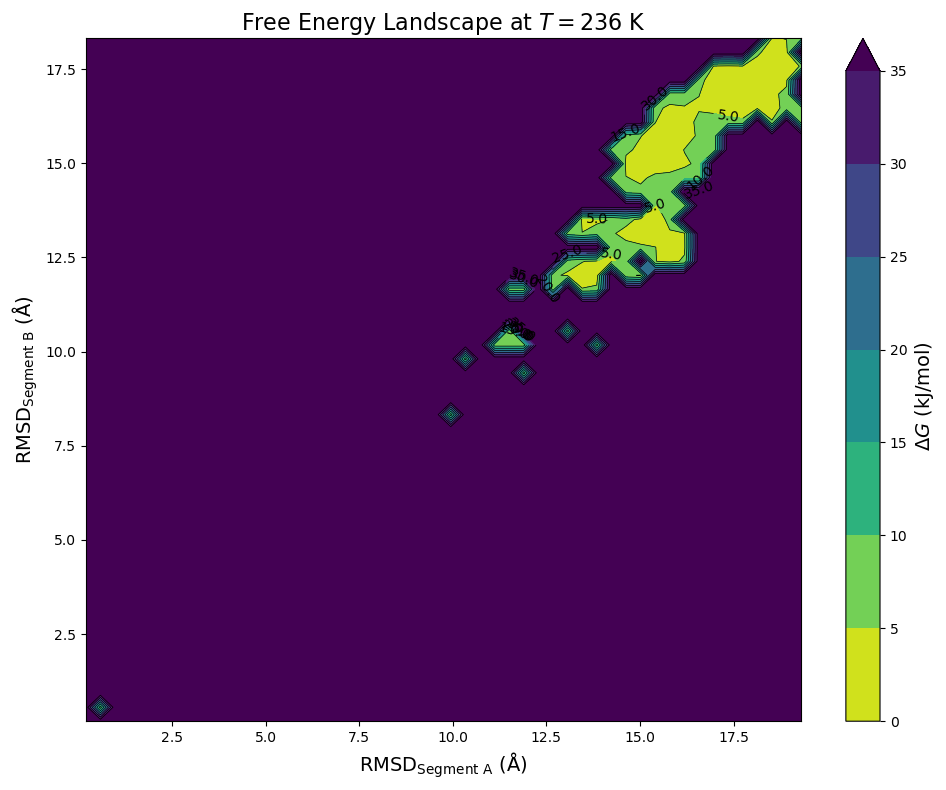

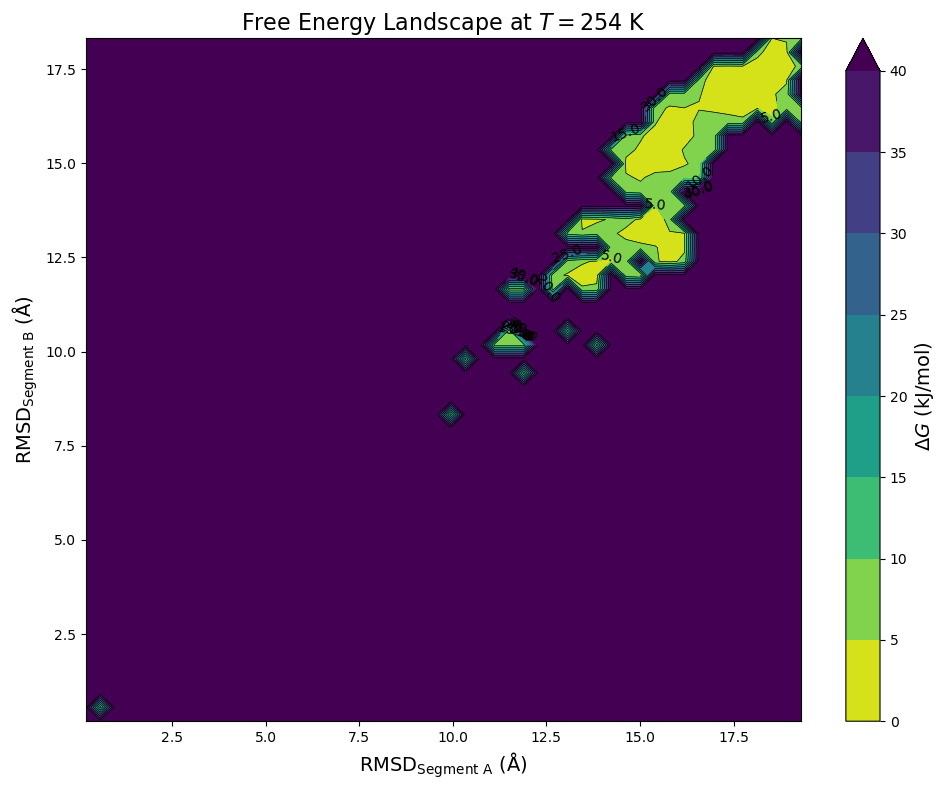

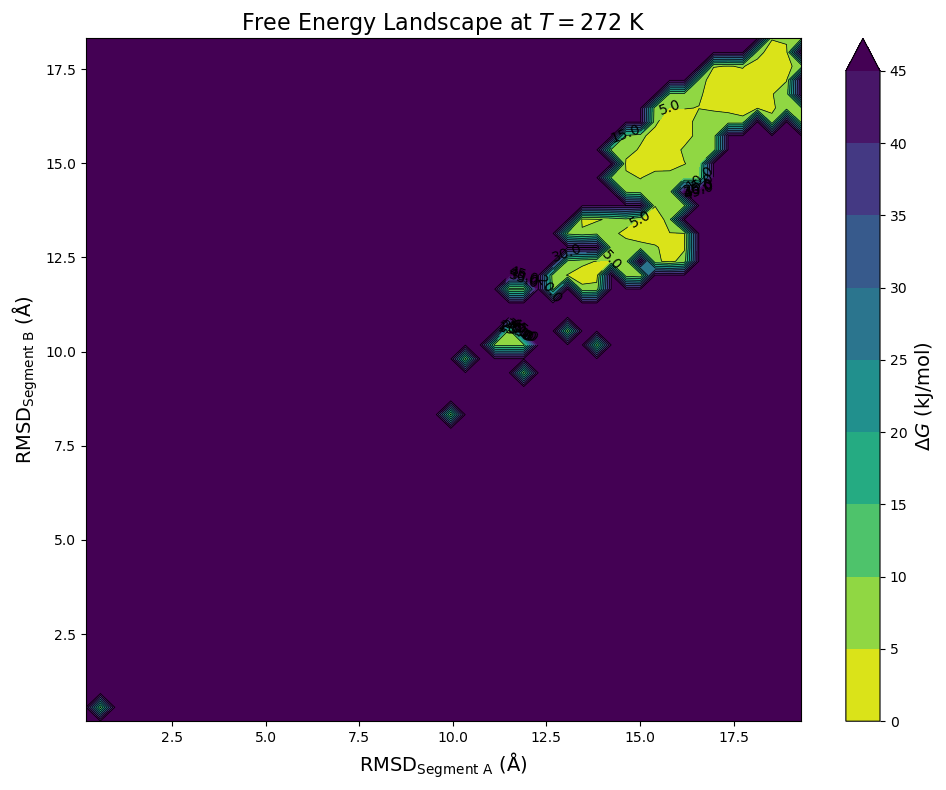

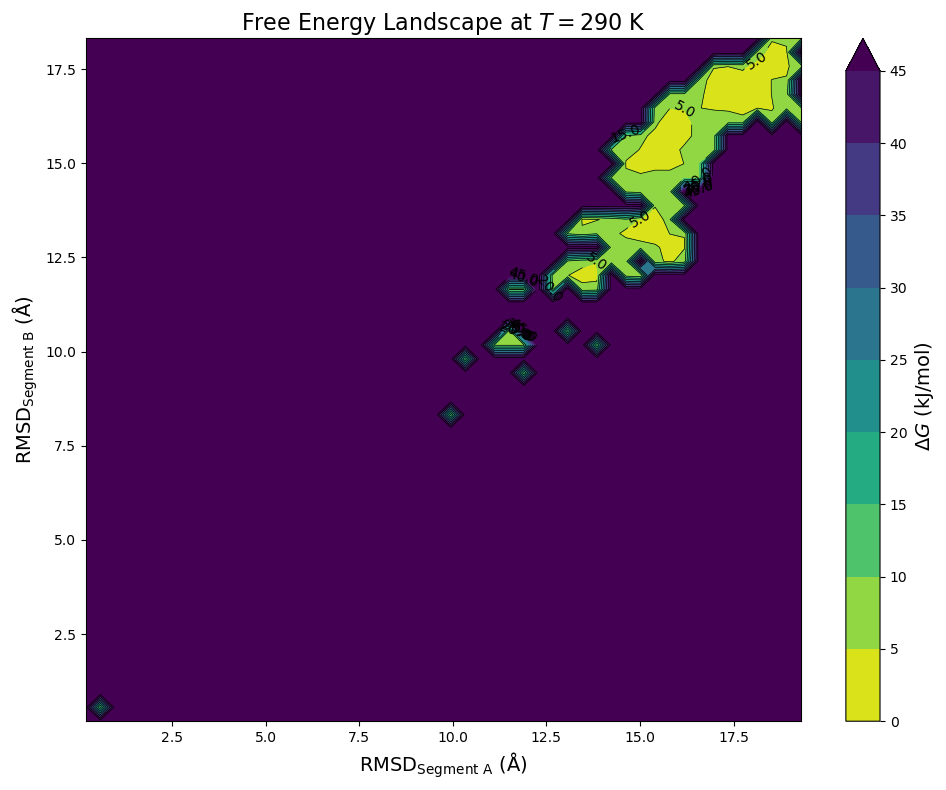

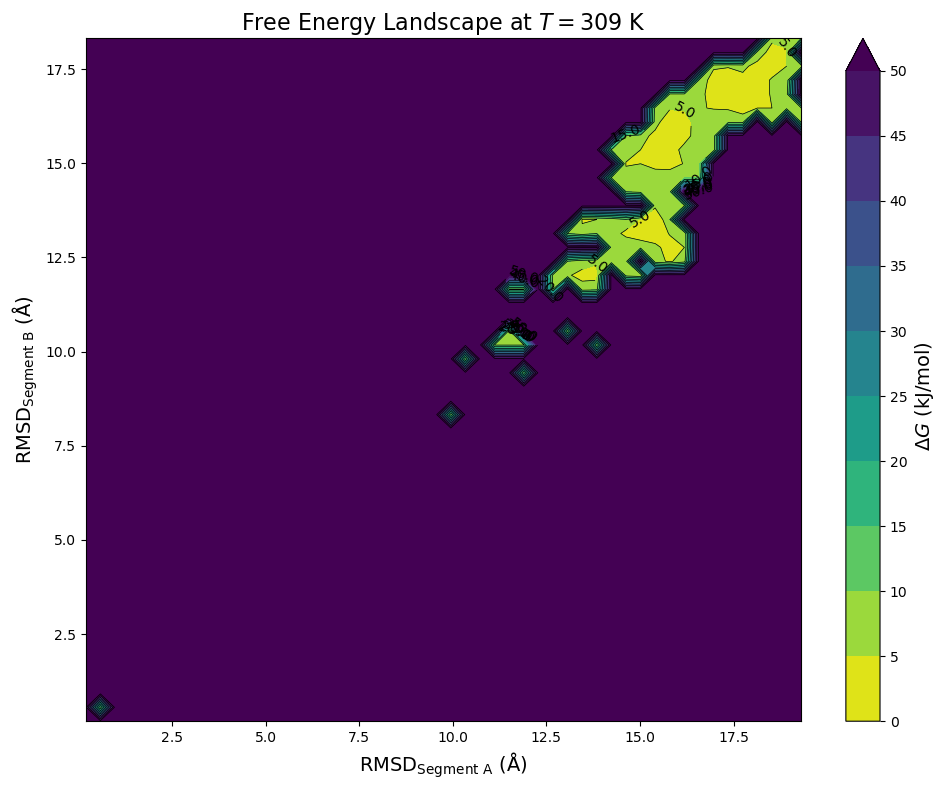

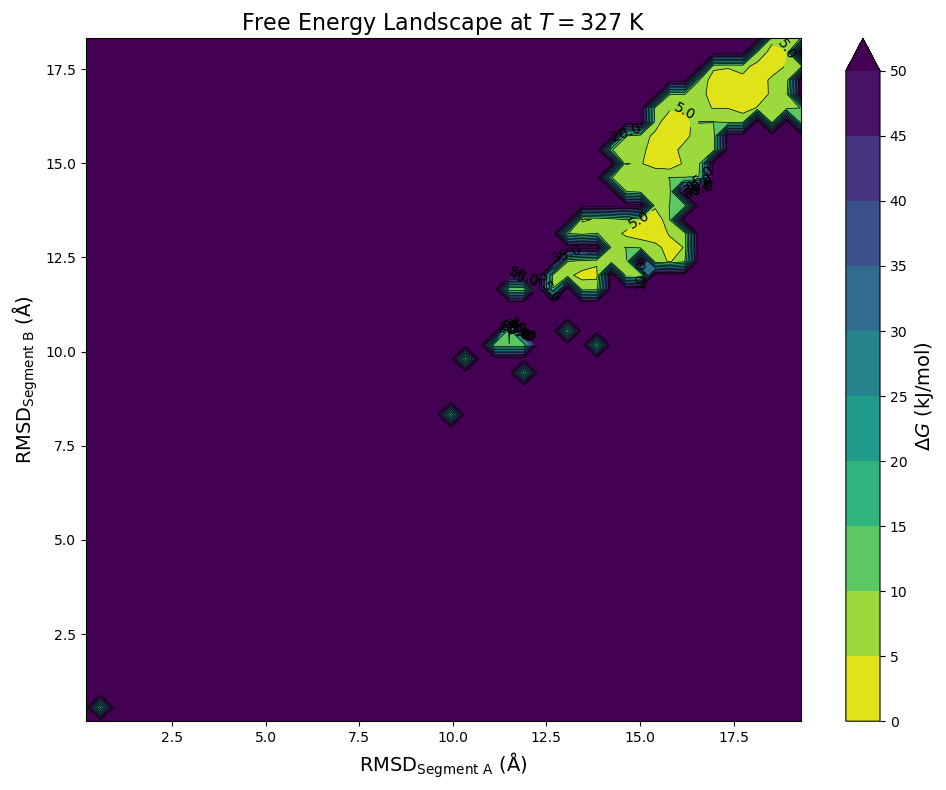

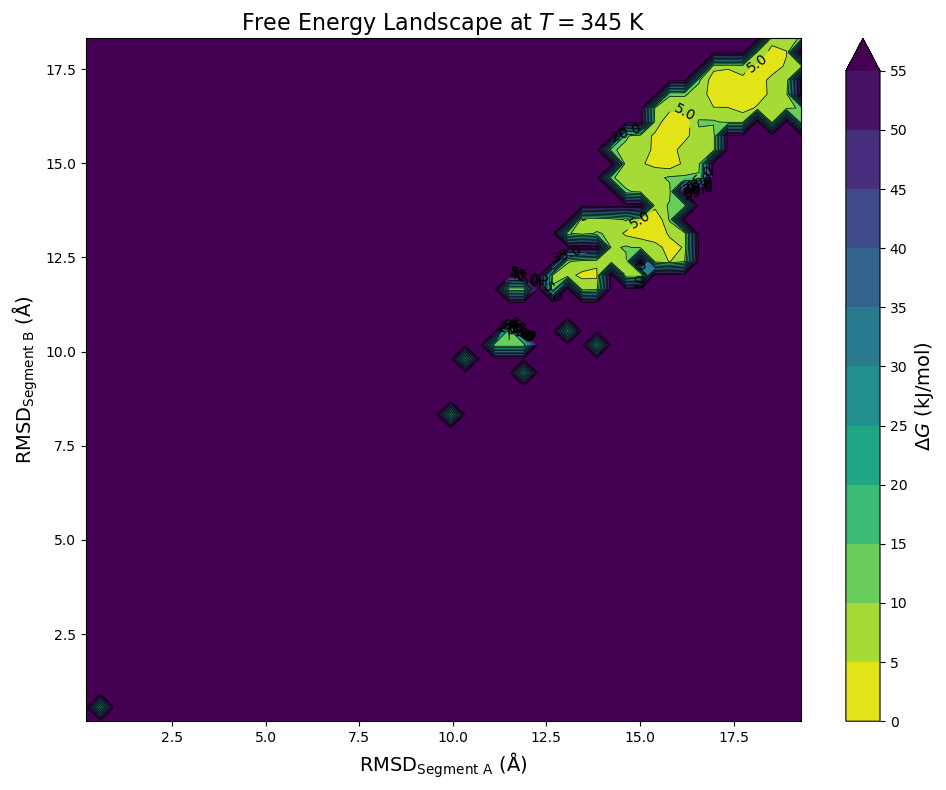

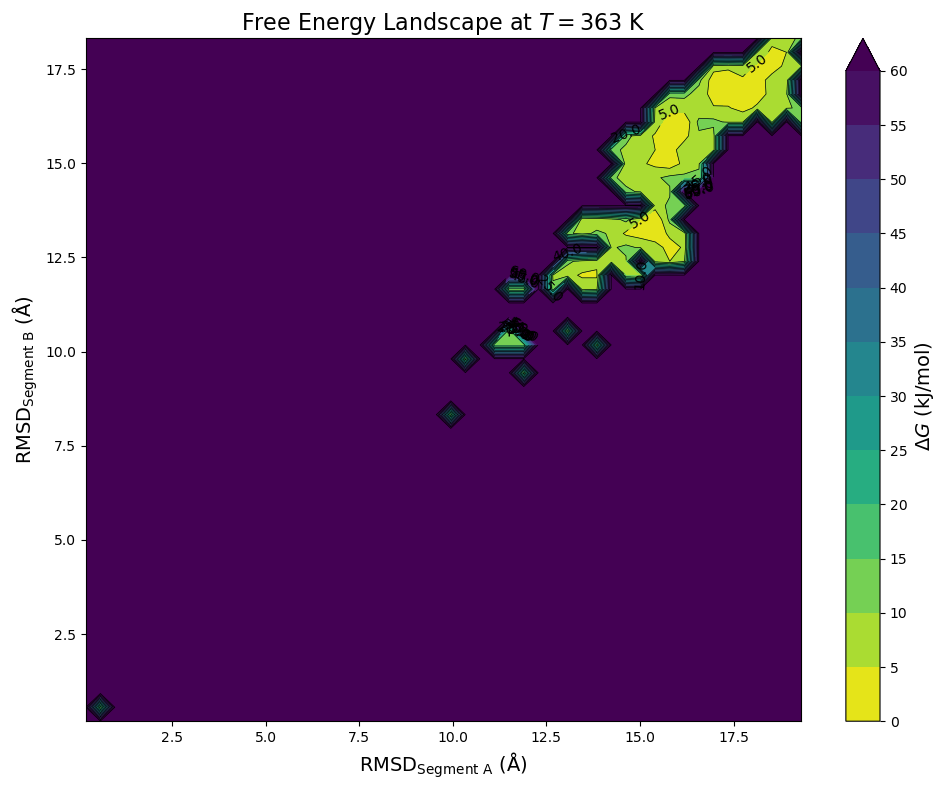

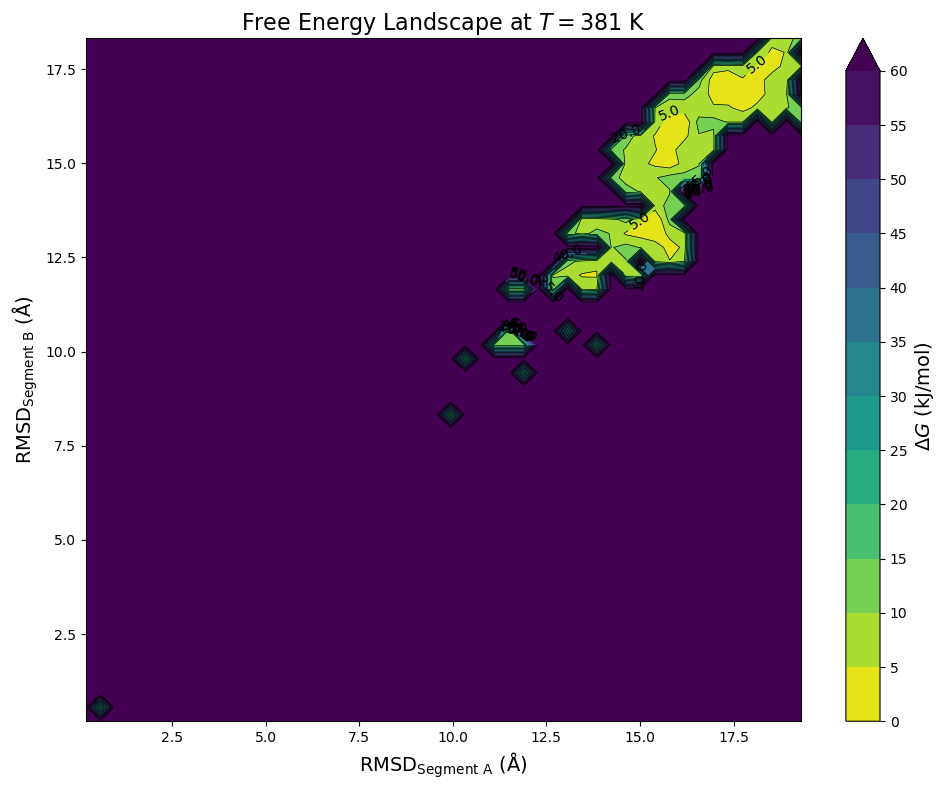

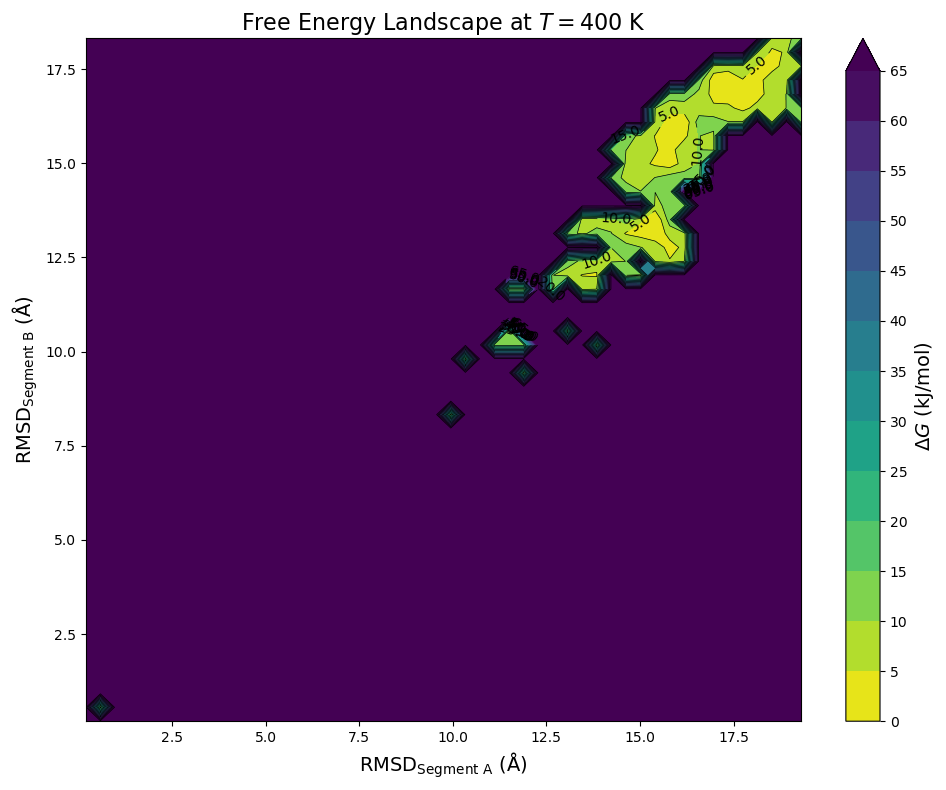

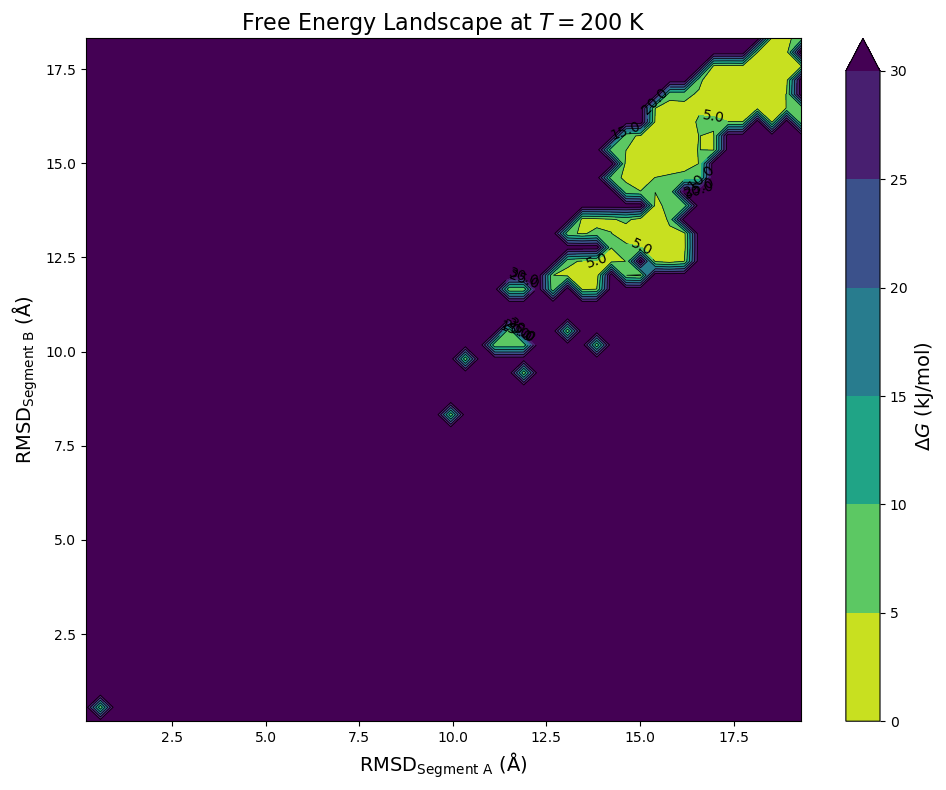

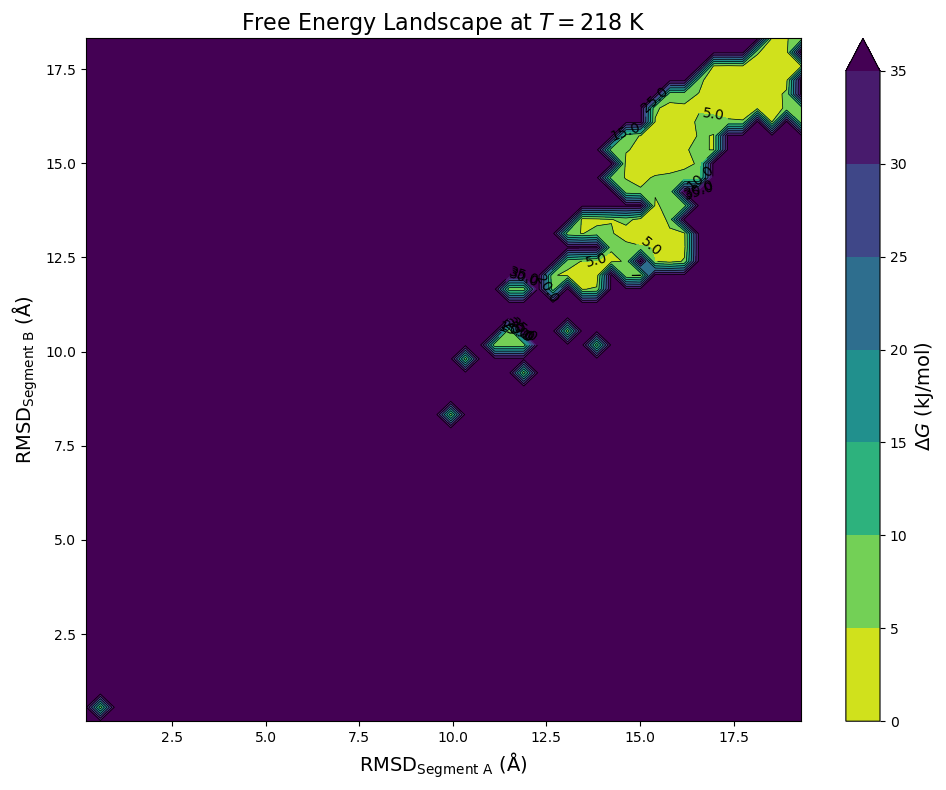

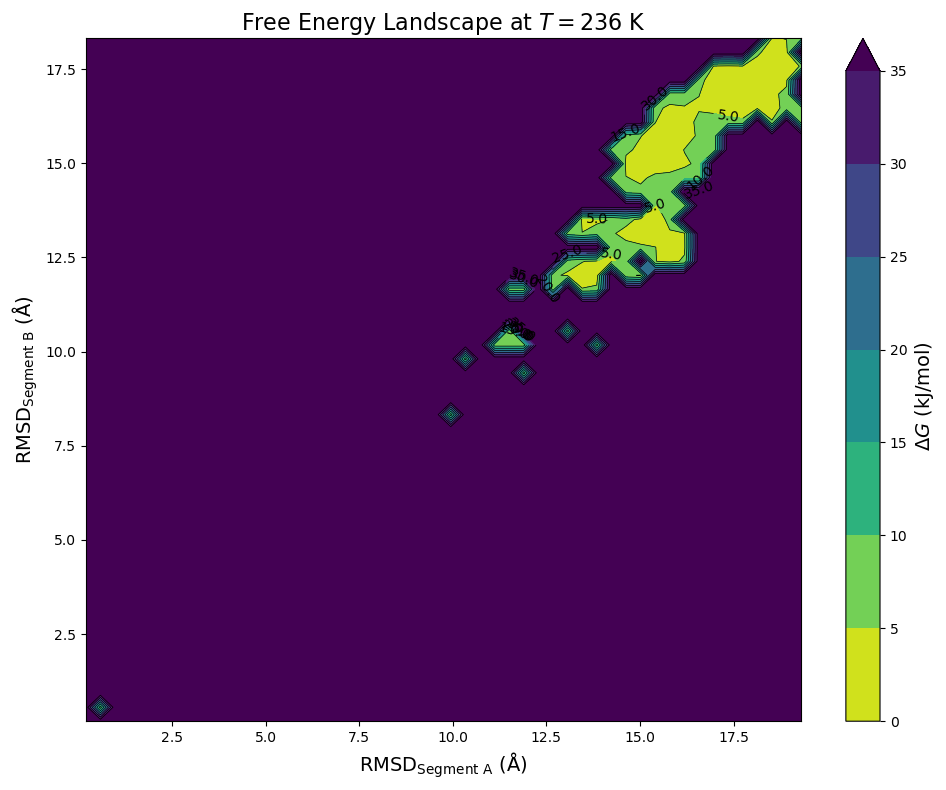

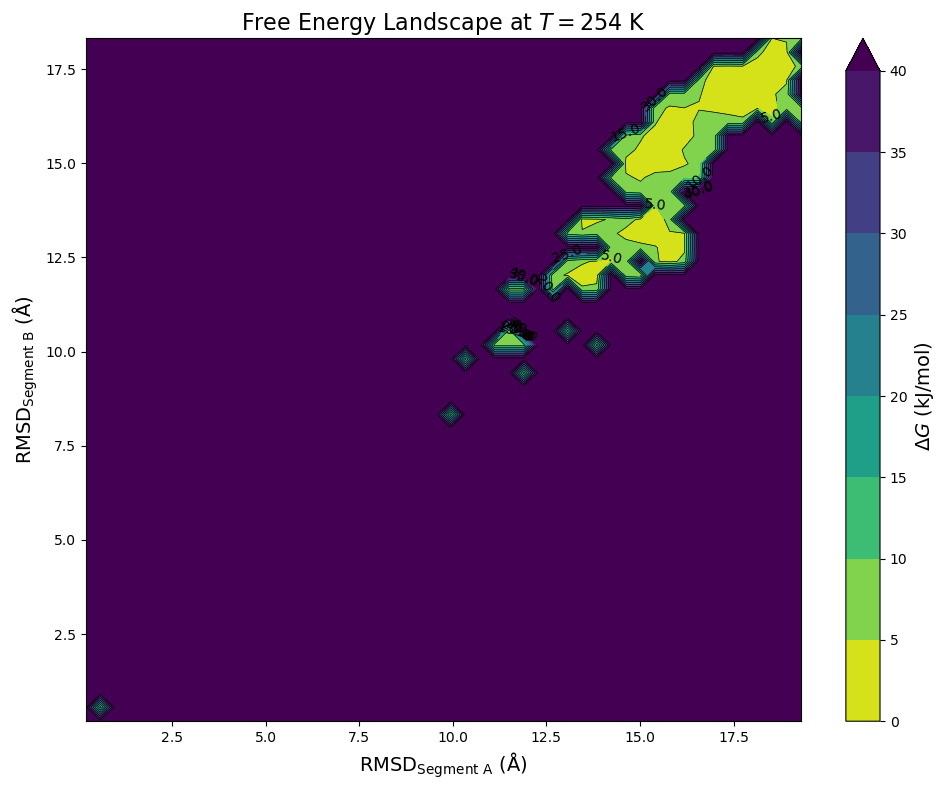

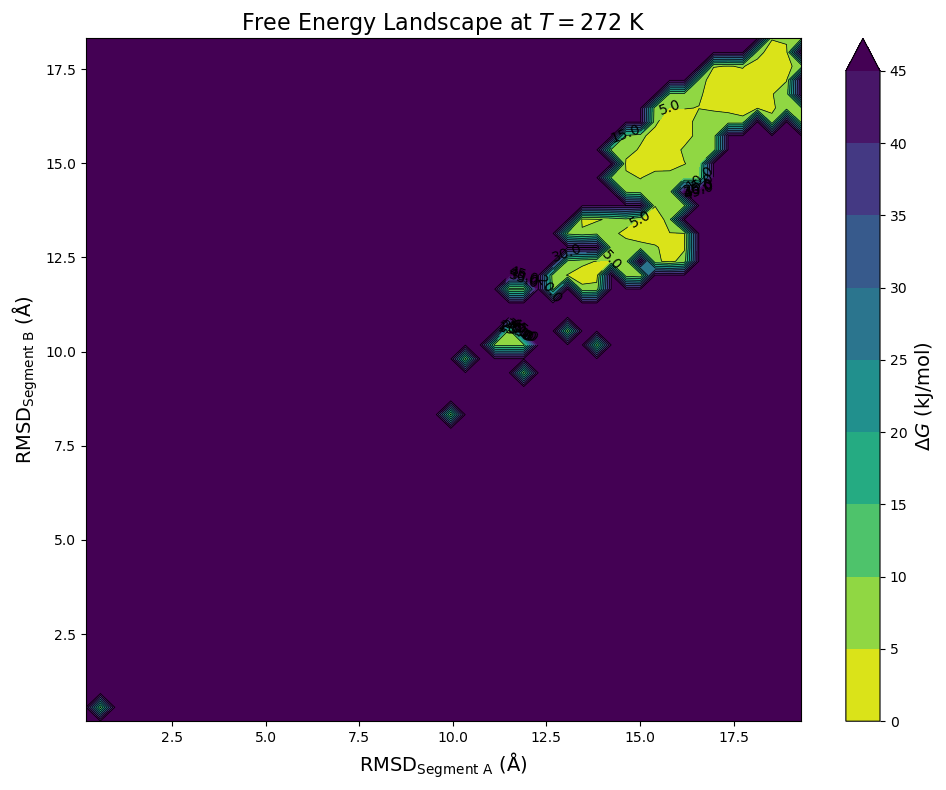

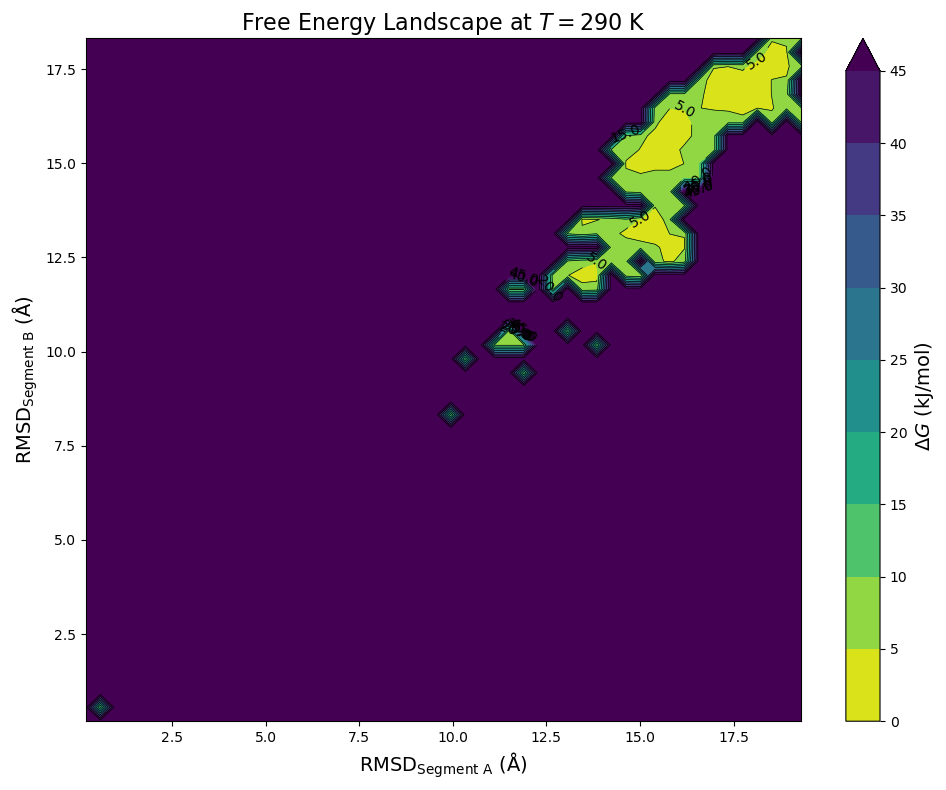

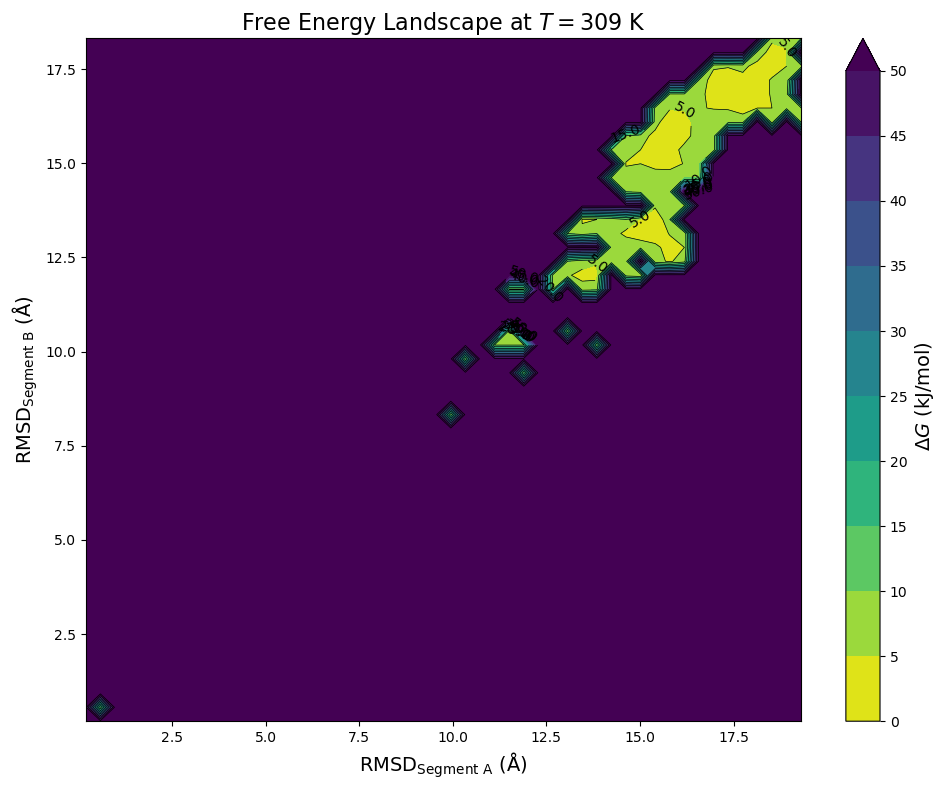

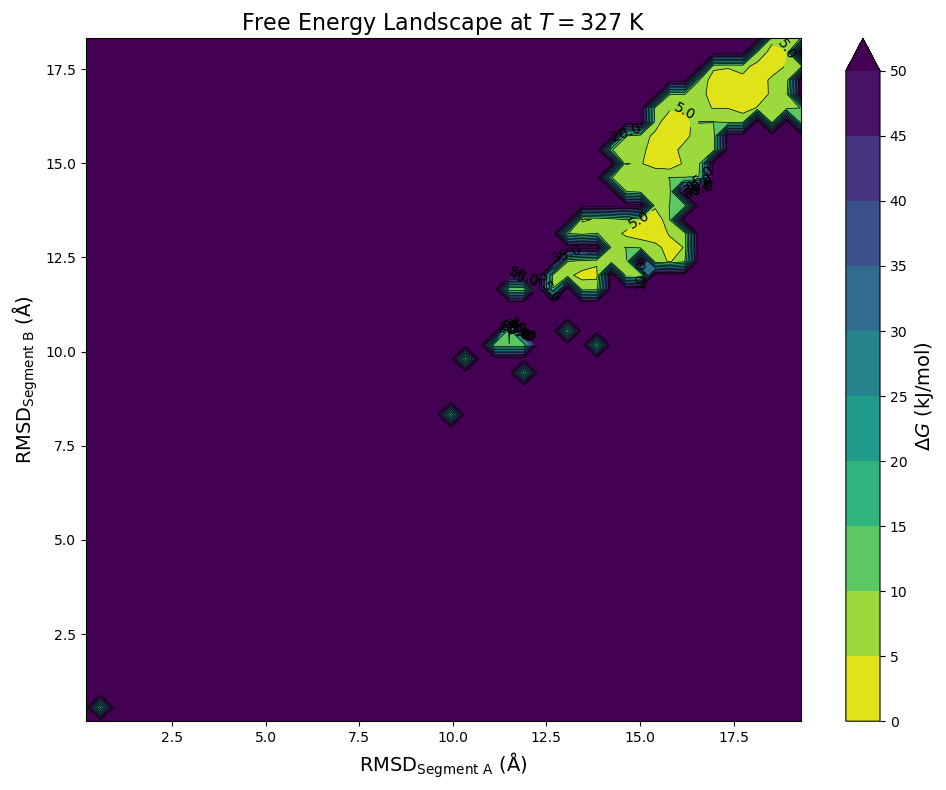

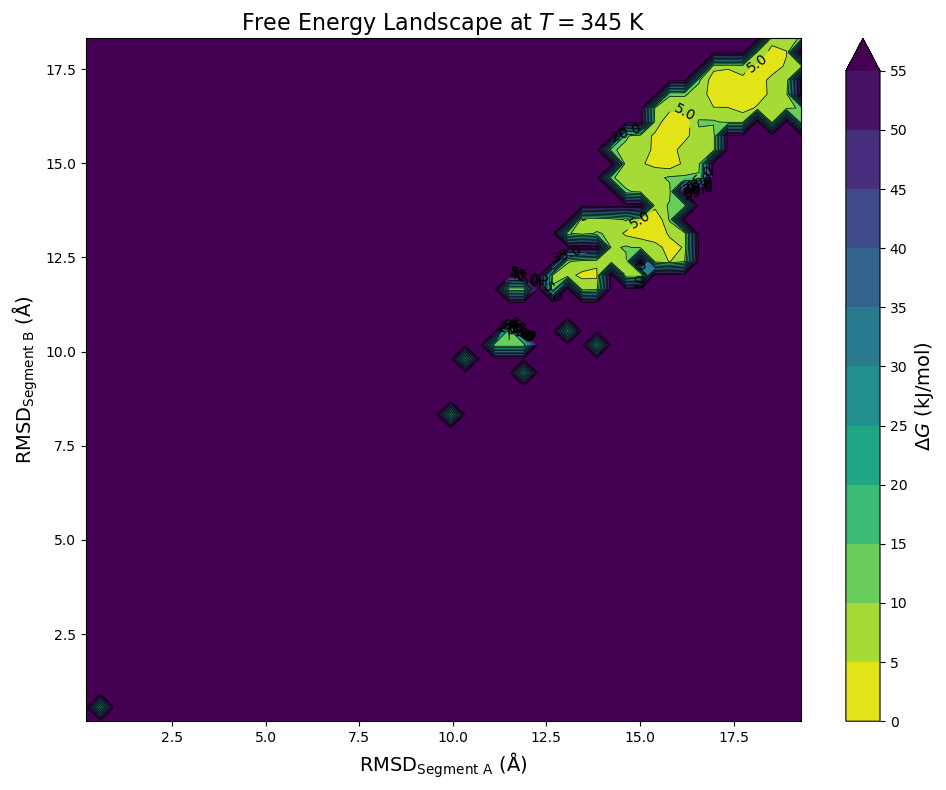

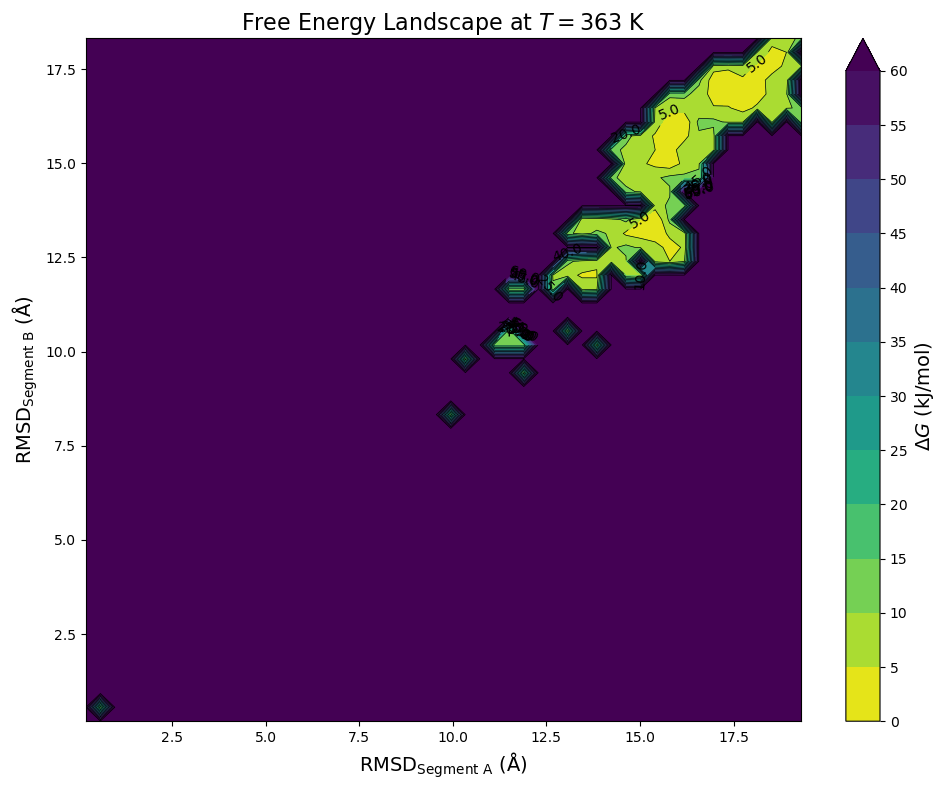

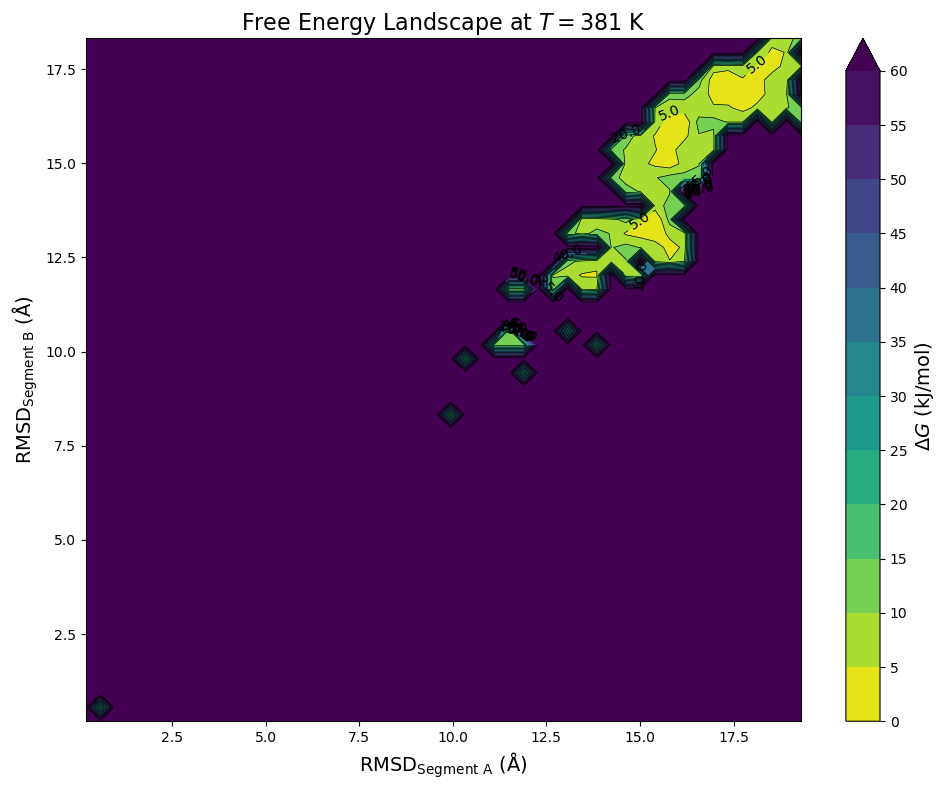

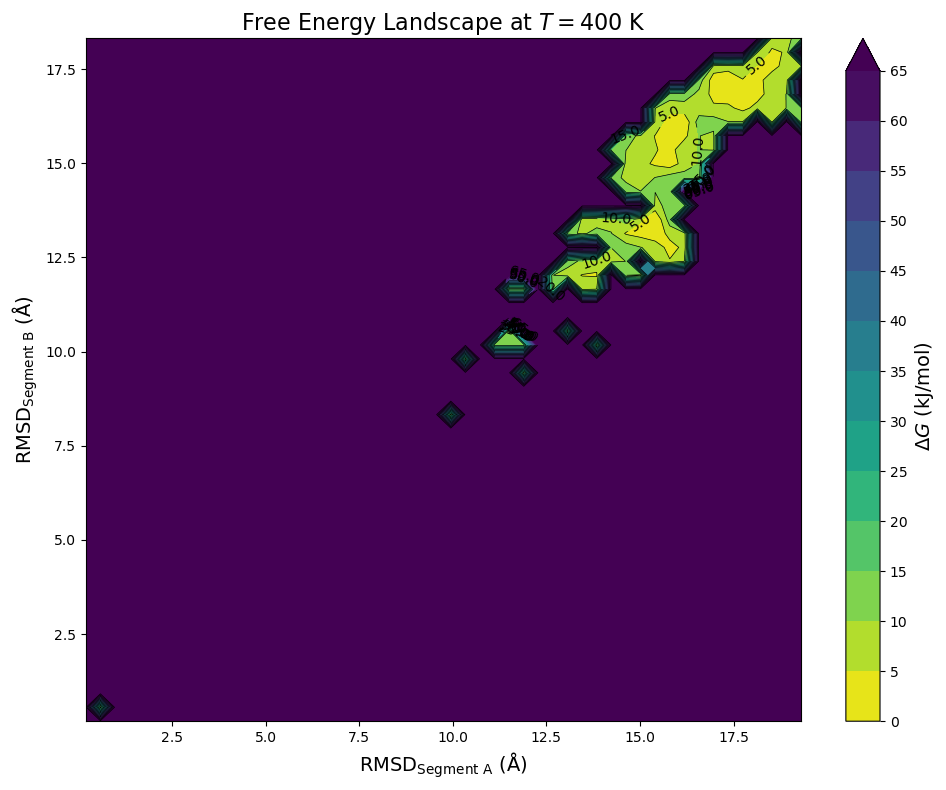

In [22]:
index_to_temp_map = {1: 200,
                     2: 218,
                     3: 236,
                     4: 254,
                     5: 272,
                     6: 290,
                     7: 309,
                     8: 327,
                     9: 345,
                     10: 363,
                     11: 381,
                     12: 400}

for file_tag, data in all_rmsd_results.items():
    plot_free_energy_landscape(rmsd_data,
                            T=index_to_temp_map[int(file_tag.split('_')[-2])],
                            filename=f"{file_tag}_free_energy_landscape.png")